In [73]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from collections import deque
import pandas as pd
import math

class NonMarkovQueueSystem:
    def __init__(self, lambda_param=1.0, mu_param=1.5, simulation_time=500, 
                 num_servers=1, queue_capacity=5, system_capacity=None):
        """
        Система массового обслуживания с полной настройкой параметров
        """
        self.lambda_param = lambda_param
        self.mu_param = mu_param
        self.simulation_time = simulation_time
        self.num_servers = num_servers
        self.queue_capacity = queue_capacity
        self.system_capacity = system_capacity if system_capacity is not None else (num_servers + (queue_capacity if queue_capacity is not None else float('inf')))
        
        # Статистика системы
        self.arrival_times = []
        self.service_times = []
        self.departure_times = []
        self.waiting_times = []
        self.system_times = []
        self.queue_length_history = []
        self.servers_busy_history = []
        self.rejected_requests = 0
        self.total_requests = 0
        
        # Для анализа состояний
        self.state_history = []
        self.state_times = []
        self.current_state = 0
        
        # Состояние системы
        self.servers = [0] * self.num_servers
        self.queue = deque()
        
    def equation_to_solve(self, x, gamma):
        """Уравнение для генерации времен: 1 - exp(-x) - x*exp(-x) = gamma"""
        return 1 - np.exp(-x) - x * np.exp(-x) - gamma
    
    def solve_for_x(self, gamma, precision=1e-8):
        """Улучшенный метод решения уравнения"""
        
        if gamma <= 0:
            return 0.001
        elif gamma >= 1:
            return 20.0  # Увеличили верхнюю границу
        
        # Функция и ее производная
        def f(x):
            return 1 - np.exp(-x) - x * np.exp(-x) - gamma
        
        def f_prime(x):
            return x * np.exp(-x)
        
        # Метод Ньютона с защитой
        x = 1.0
        for iteration in range(100):
            fx = f(x)
            
            if abs(fx) < precision:
                return x
            
            fpx = f_prime(x)
            
            # Защита от нулевой производной
            if abs(fpx) < 1e-12:
                # Переключаемся на бисекцию
                return self._solve_bisection_safe(gamma, precision)
            
            x_new = x - fx / fpx
            
            # Защита от выхода за границы
            if x_new < 0.001:
                x_new = 0.001
            elif x_new > 20.0:
                x_new = 20.0
                
            # Проверка сходимости
            if abs(x_new - x) < precision:
                return x_new
                
            x = x_new
        
        # Если не сошлось, используем бисекцию
        return self._solve_bisection_safe(gamma, precision)

    def _solve_bisection_safe(self, gamma, precision=1e-8):
        """Надежный метод бисекции"""
        left, right = 0.001, 20.0
        
        # Проверяем, что решение существует в интервале
        f_left = 1 - np.exp(-left) - left * np.exp(-left) - gamma
        f_right = 1 - np.exp(-right) - right * np.exp(-right) - gamma
        
        if f_left * f_right > 0:
            # Расширяем интервал
            right = 50.0
            f_right = 1 - np.exp(-right) - right * np.exp(-right) - gamma
        
        for iteration in range(200):
            mid = (left + right) / 2
            f_mid = 1 - np.exp(-mid) - mid * np.exp(-mid) - gamma
            
            if abs(f_mid) < precision:
                return mid
            elif f_mid < 0:
                left = mid
            else:
                right = mid
        
        return (left + right) / 2
    
    def generate_interarrival_time(self):
        """Генерация времени между поступлениями заявок"""
        # Гамма имеет равномерное распределение от 0 до 1
        gamma_i = np.random.uniform(0, 1)
        x_solution = self.solve_for_x(gamma_i)
        
        # Преобразуем в физическое время
        T_i = x_solution / self.lambda_param
        return max(0.001, T_i)
    
    def generate_service_time(self):
        """Генерация времени обслуживания заявки"""
        # Гамма имеет равномерное распределение от 0 до 1
        gamma_j = np.random.uniform(0, 1)
        x_solution = self.solve_for_x(gamma_j)
        
        # Преобразуем в физическое время
        tau_j = x_solution / self.mu_param
        return max(0.001, tau_j)
    
    def analyze_gamma_distribution(self):
        """Анализ распределения гамма и соответствующих времен"""
        n_samples = 10000
        gamma_samples = np.random.uniform(0, 1, n_samples)
        x_solutions = [self.solve_for_x(gamma) for gamma in gamma_samples]
        times = [x / self.lambda_param for x in x_solutions]
        
        print(f"\nАнализ распределения γ и времен (n={n_samples} samples)")
        print("="*60)
        
        print(f"Распределение γ:")
        print(f"  Мин: {gamma_samples.min():.6f}")
        print(f"  Макс: {gamma_samples.max():.6f}")
        print(f"  Среднее: {gamma_samples.mean():.6f}")
        print(f"  Стандартное отклонение: {gamma_samples.std():.6f}")
        
        print(f"\nРаспределение x (решения уравнения):")
        print(f"  Мин: {min(x_solutions):.6f}")
        print(f"  Макс: {max(x_solutions):.6f}")
        print(f"  Среднее: {np.mean(x_solutions):.6f}")
        
        print(f"\nРаспределение времени между заявками:")
        print(f"  Мин: {min(times):.6f}")
        print(f"  Макс: {max(times):.6f}")
        print(f"  Среднее: {np.mean(times):.6f}")
        print(f"  Отрицательные значения: {sum(1 for t in times if t < 0)}")
        
        # Визуализация
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Распределение гамма
        ax1.hist(gamma_samples, bins=50, alpha=0.7, color='lightblue', edgecolor='black', density=True)
        ax1.set_title('Распределение γ ~ Uniform(0, 1)', fontweight='bold')
        ax1.set_xlabel('γ')
        ax1.set_ylabel('Плотность вероятности')
        ax1.grid(True, alpha=0.3)
        
        # 2. Зависимость x от гамма
        ax2.scatter(gamma_samples, x_solutions, alpha=0.5, s=1, color='red')
        ax2.set_title('Зависимость x от γ\nx: решение уравнения F(x) = γ', fontweight='bold')
        ax2.set_xlabel('γ')
        ax2.set_ylabel('x')
        ax2.grid(True, alpha=0.3)
        
        # 3. Распределение времени между заявками
        ax3.hist(times, bins=50, alpha=0.7, color='green', edgecolor='black', density=True)
        ax3.set_title('Распределение времени между заявками', fontweight='bold')
        ax3.set_xlabel('Время')
        ax3.set_ylabel('Плотность вероятности')
        ax3.grid(True, alpha=0.3)
        
        # 4. Функция распределения F(x) = 1 - e^{-x} - x e^{-x}
        x_values = np.linspace(0.001, 5, 1000)
        F_x = 1 - np.exp(-x_values) - x_values * np.exp(-x_values)
        ax4.plot(x_values, F_x, 'b-', linewidth=2, label='F(x) = 1 - e^{-x} - x e^{-x}')
        ax4.set_title('Функция распределения F(x)', fontweight='bold')
        ax4.set_xlabel('x')
        ax4.set_ylabel('F(x)')
        ax4.grid(True, alpha=0.3)
        ax4.legend()
        
        plt.tight_layout()
        plt.show()
        
        return gamma_samples, x_solutions, times
    
    def calculate_performance_metrics(self):
        """Расчет основных характеристик СМО"""
        if not self.arrival_times:
            return {}
        
        served_requests = len(self.arrival_times)
        total_requests = self.total_requests
        
        # Проверка согласованности
        if served_requests + self.rejected_requests != total_requests:
            print("⚠️  Обнаружено несоответствие в подсчете заявок")
            total_requests = served_requests + self.rejected_requests
        
        # Основные временные характеристики
        avg_waiting_time = np.mean(self.waiting_times) if self.waiting_times else 0
        avg_service_time = np.mean(self.service_times) if self.service_times else 0
        avg_system_time = np.mean(self.system_times) if self.system_times else 0
        
        # Характеристики очереди
        avg_queue_length = np.mean(self.queue_length_history) if self.queue_length_history else 0
        max_queue_length = np.max(self.queue_length_history) if self.queue_length_history else 0
        
        # Характеристики каналов
        avg_busy_servers = np.mean(self.servers_busy_history) if self.servers_busy_history else 0
        server_utilization = avg_busy_servers / self.num_servers if self.num_servers > 0 else 0
        
        metrics = {
            # Основные метрики
            'total_requests': total_requests,
            'served_requests': served_requests,
            'rejected_requests': self.rejected_requests,
            'rejection_probability': self.rejected_requests / total_requests if total_requests > 0 else 0,
            'simulation_time': self.simulation_time,
            
            # Временные характеристики
            'avg_waiting_time': avg_waiting_time,
            'avg_service_time': avg_service_time,
            'avg_system_time': avg_system_time,
            'max_waiting_time': np.max(self.waiting_times) if self.waiting_times else 0,
            
            # Характеристики очереди
            'avg_queue_length': avg_queue_length,
            'max_queue_length': max_queue_length,
            'queue_probability': np.mean([ql > 0 for ql in self.queue_length_history]) if self.queue_length_history else 0,
            
            # Характеристики каналов
            'avg_busy_servers': avg_busy_servers,
            'server_utilization': server_utilization,
            'immediate_service_prob': np.mean([wt == 0 for wt in self.waiting_times]) if self.waiting_times else 0,
            
            # Загрузка системы
            'traffic_intensity': (self.lambda_param) / (self.num_servers * (self.mu_param)) if self.num_servers * (self.mu_param) > 0 else 0,
            'throughput': served_requests / self.simulation_time,
        }
        
        return metrics
    
    def plot_state_analysis(self):
        """Визуализация анализа состояний СМО"""
        if not self.state_times:
            print("Нет данных для анализа состояний")
            return
        
        limiting_probs, theoretical_probs, total_time = self.calculate_limiting_probabilities()
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Анализ состояний СМО и предельные вероятности', fontsize=16, fontweight='bold')
        
        # 1. График состояний системы во времени
        if self.state_history:
            times, states = zip(*self.state_history)
            ax1.step(times, states, where='post', linewidth=1.5, color='blue', alpha=0.8)
            ax1.set_title('Динамика состояний системы во времени', fontweight='bold')
            ax1.set_xlabel('Время')
            ax1.set_ylabel('Число заявок в системе')
            ax1.grid(True, alpha=0.3)
            ax1.set_ylim(bottom=0)
        
        # 2. Предельные вероятности (эмпирические)
        states_empirical = list(limiting_probs.keys())
        probs_empirical = list(limiting_probs.values())
        
        ax2.bar(states_empirical, probs_empirical, alpha=0.7, color='green', 
                label='Эмпирические', edgecolor='black')
        ax2.set_title('Эмпирические предельные вероятности', fontweight='bold')
        ax2.set_xlabel('Состояние (число заявок в системе)')
        ax2.set_ylabel('Вероятность')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. Сравнение эмпирических и теоретических вероятностей
        states_theoretical = list(theoretical_probs.keys())
        probs_theoretical = list(theoretical_probs.values())
        
        # Совмещаем состояния
        all_states = sorted(set(states_empirical + states_theoretical))
        empirical_probs_aligned = [limiting_probs.get(state, 0) for state in all_states]
        theoretical_probs_aligned = [theoretical_probs.get(state, 0) for state in all_states]
        
        x_pos = np.arange(len(all_states))
        width = 0.35
        
        ax3.bar(x_pos - width/2, empirical_probs_aligned, width, 
                alpha=0.7, color='green', label='Эмпирические', edgecolor='black')
        ax3.bar(x_pos + width/2, theoretical_probs_aligned, width, 
                alpha=0.7, color='red', label='Теоретические (M/M/n)', edgecolor='black')
        
        ax3.set_title('Сравнение эмпирических и теоретических вероятностей', fontweight='bold')
        ax3.set_xlabel('Состояние (число заявок в системе)')
        ax3.set_ylabel('Вероятность')
        ax3.set_xticks(x_pos)
        ax3.set_xticklabels(all_states)
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 4. Распределение времени пребывания в состояниях
        state_numbers = [state for state, time in self.state_times]
        state_durations = [time for state, time in self.state_times]
        
        ax4.scatter(state_numbers, state_durations, alpha=0.6, color='purple', s=50)
        ax4.set_title('Распределение времени пребывания в состояниях', fontweight='bold')
        ax4.set_xlabel('Состояние')
        ax4.set_ylabel('Время пребывания')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Вывод таблицы вероятностей
        self._print_probabilities_table(limiting_probs, theoretical_probs)

    def _print_probabilities_table(self, limiting_probs, theoretical_probs):
        """Вывод таблицы с вероятностями состояний"""
        print("\n" + "="*80)
        print("ТАБЛИЦА ПРЕДЕЛЬНЫХ ВЕРОЯТНОСТЕЙ СОСТОЯНИЙ СИСТЕМЫ")
        print("="*80)
        
        # Совмещаем состояния для сравнения
        all_states = sorted(set(list(limiting_probs.keys()) + list(theoretical_probs.keys())))
        
        data = []
        for state in all_states:
            emp_prob = limiting_probs.get(state, 0)
            theor_prob = theoretical_probs.get(state, 0)
            error = abs(emp_prob - theor_prob) if theor_prob > 0 else 0
            
            data.append({
                'Состояние': state,
                'Эмпирическая': f"{emp_prob:.6f}",
                'Теоретическая': f"{theor_prob:.6f}",
                'Ошибка': f"{error:.6f}",
                'Описание': self._get_state_description(state)
            })
        
        df = pd.DataFrame(data)
        print(df.to_string(index=False))
        
        # Суммарные вероятности
        total_emp = sum(limiting_probs.values())
        total_theor = sum(theoretical_probs.values())
        print(f"\nСумма эмпирических вероятностей: {total_emp:.6f}")
        print(f"Сумма теоретических вероятностей: {total_theor:.6f}")

    def _get_state_description(self, state):
        """Описание состояния системы"""
        if state == 0:
            return "Система пуста"
        elif state <= self.num_servers:
            return f"{state} заявок в обслуживании"
        else:
            queue_length = state - self.num_servers
            return f"{self.num_servers} в обслуживании, {queue_length} в очереди"

    def print_detailed_report(self):
        """Вывод детального отчета по системе"""
        metrics = self.calculate_performance_metrics()
        
        print("\n" + "="*60)
        print("ДЕТАЛЬНЫЙ ОТЧЕТ ПО СИСТЕМЕ МАССОВОГО ОБСЛУЖИВАНИЯ")
        print("="*60)
        
        print(f"\n📈 ОСНОВНЫЕ ХАРАКТЕРИСТИКИ:")
        print(f"   Всего заявок: {metrics['total_requests']}")
        print(f"   Обслужено заявок: {metrics['served_requests']}")
        print(f"   Отклонено заявок: {metrics['rejected_requests']}")
        print(f"   Вероятность отказа: {metrics['rejection_probability']:.4f}")
        print(f"   Пропускная способность: {metrics['throughput']:.4f} заявок/ед.времени")
        
        print(f"\n⏱️  ВРЕМЕННЫЕ ХАРАКТЕРИСТИКИ:")
        print(f"   Среднее время ожидания: {metrics['avg_waiting_time']:.4f}")
        print(f"   Среднее время обслуживания: {metrics['avg_service_time']:.4f}")
        print(f"   Среднее время в системе: {metrics['avg_system_time']:.4f}")
        print(f"   Максимальное время ожидания: {metrics['max_waiting_time']:.4f}")
        
        print(f"\n📊 ХАРАКТЕРИСТИКИ ОЧЕРЕДИ:")
        print(f"   Средняя длина очереди: {metrics['avg_queue_length']:.4f}")
        print(f"   Максимальная длина очереди: {metrics['max_queue_length']}")
        print(f"   Вероятность очереди: {metrics['queue_probability']:.4f}")
        
        print(f"\n⚙️  ХАРАКТЕРИСТИКИ КАНАЛОВ:")
        print(f"   Среднее число занятых каналов: {metrics['avg_busy_servers']:.4f}")
        print(f"   Коэффициент использования каналов: {metrics['server_utilization']:.4f}")
        print(f"   Вероятность немедленного обслуживания: {metrics['immediate_service_prob']:.4f}")
        print(f"   Теоретическая нагрузка: {metrics['traffic_intensity']:.4f}")
        
        # Проверка стабильности
        if metrics['traffic_intensity'] < 1:
            print(f"\n✅ СИСТЕМА СТАБИЛЬНА (ρ < 1)")
        else:
            print(f"\n⚠️  СИСТЕМА ПЕРЕГРУЖЕНА (ρ ≥ 1)")
        
        return metrics

    def plot_comprehensive_results(self):
        """Комплексная визуализация всех результатов"""
        if not self.arrival_times:
            print("Нет данных для визуализации")
            return
        
        fig = plt.figure(figsize=(20, 15))
        fig.suptitle('Комплексный анализ СМО с немарковским потоком', fontsize=16, fontweight='bold')
        
        # 1. Распределение времени обслуживания
        plt.subplot(3, 3, 1)
        plt.hist(self.service_times, bins=30, alpha=0.7, color='lightcoral', edgecolor='black', density=True)
        plt.title('Распределение времени обслуживания', fontweight='bold')
        plt.xlabel('Время обслуживания')
        plt.ylabel('Плотность вероятности')
        plt.grid(True, alpha=0.3)
        
        # 2. Распределение времени ожидания
        plt.subplot(3, 3, 2)
        plt.hist(self.waiting_times, bins=30, alpha=0.7, color='gold', edgecolor='black', density=True)
        plt.title('Распределение времени ожидания', fontweight='bold')
        plt.xlabel('Время ожидания')
        plt.ylabel('Плотность вероятности')
        plt.grid(True, alpha=0.3)
        
        # 3. Длина очереди во времени
        plt.subplot(3, 3, 3)
        plt.plot(self.queue_length_history, 'g-', alpha=0.7, linewidth=1)
        plt.title('Длина очереди во времени', fontweight='bold')
        plt.xlabel('Номер события')
        plt.ylabel('Длина очереди')
        plt.grid(True, alpha=0.3)
        
        # 4. Количество занятых каналов во времени
        plt.subplot(3, 3, 4)
        plt.plot(self.servers_busy_history, 'r-', alpha=0.7, linewidth=1)
        plt.title('Количество занятых каналов во времени', fontweight='bold')
        plt.xlabel('Номер события')
        plt.ylabel('Занятые каналы')
        plt.ylim(0, self.num_servers)
        plt.grid(True, alpha=0.3)
        
        # 5. Время в системе vs Время обслуживания
        plt.subplot(3, 3, 5)
        plt.scatter(self.service_times, self.system_times, alpha=0.6, color='purple', s=20)
        max_val = max(max(self.service_times), max(self.system_times)) if self.system_times else 1
        plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, label='y = x')
        plt.title('Время в системе vs Время обслуживания', fontweight='bold')
        plt.xlabel('Время обслуживания')
        plt.ylabel('Время в системе')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 6. Накопленное количество заявок
        plt.subplot(3, 3, 6)
        cumulative_arrivals = range(1, len(self.arrival_times) + 1)
        plt.plot(self.arrival_times, cumulative_arrivals, 'b-', linewidth=2)
        plt.title('Накопленное количество заявок', fontweight='bold')
        plt.xlabel('Время')
        plt.ylabel('Количество заявок')
        plt.grid(True, alpha=0.3)
        
        # 7. Соотношение времени ожидания и обслуживания
        plt.subplot(3, 3, 7)
        indices = range(min(50, len(self.waiting_times)))
        if indices:
            bar_width = 0.35
            x_pos = np.arange(len(indices))
            plt.bar(x_pos - bar_width/2, 
                    [self.waiting_times[i] for i in indices], 
                    bar_width, label='Ожидание', alpha=0.7, color='red')
            plt.bar(x_pos + bar_width/2, 
                    [self.service_times[i] for i in indices], 
                    bar_width, label='Обслуживание', alpha=0.7, color='blue')
            plt.title('Сравнение времени ожидания и обслуживания\n(первые 50 заявок)', fontweight='bold')
            plt.xlabel('Номер заявки')
            plt.ylabel('Время')
            plt.legend()
            plt.grid(True, alpha=0.3)
        
        # 8. Круговая диаграмма - распределение времени
        plt.subplot(3, 3, 8)
        if self.waiting_times and self.service_times:
            total_waiting = np.sum(self.waiting_times)
            total_service = np.sum(self.service_times)
            total_system = np.sum(self.system_times)
            
            labels = ['Ожидание', 'Обслуживание']
            sizes = [total_waiting, total_service]
            colors = ['lightcoral', 'lightskyblue']
            
            plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
            plt.title('Распределение общего времени\nв системе', fontweight='bold')
        
        plt.tight_layout()
        plt.show()


    def analyze_equation_behavior(self):
        """Анализ поведения исходного уравнения"""
        x_values = np.linspace(0.001, 5, 200)
        y_values = 1 - np.exp(-x_values) - x_values * np.exp(-x_values)
        
        plt.figure(figsize=(12, 8))
        plt.plot(x_values, y_values, 'b-', linewidth=3, label='F(x) = 1 - e^{-x} - x e^{-x}')
        plt.fill_between(x_values, y_values, alpha=0.2, color='blue')
        
        # Добавляем примеры решений для равномерно распределенных гамма
        test_gammas = np.linspace(0.1, 0.9, 9)
        colors = plt.cm.viridis(np.linspace(0, 1, len(test_gammas)))
        
        for gamma, color in zip(test_gammas, colors):
            x_sol = self.solve_for_x(gamma)
            plt.plot([x_sol, x_sol], [0, gamma], '--', color=color, alpha=0.7)
            plt.plot([0, x_sol], [gamma, gamma], '--', color=color, alpha=0.7)
            plt.plot(x_sol, gamma, 'o', color=color, markersize=8, 
                    label=f'γ={gamma:.1f}, x={x_sol:.3f}')
        
        plt.xlabel('x', fontsize=12)
        plt.ylabel('F(x)', fontsize=12)
        plt.title('Функция распределения F(x) = 1 - e^{-x} - x e^{-x}\nс примерами решений для равномерного γ', 
                 fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    def simulate_queue_system(self):
        """Основной метод моделирования СМО"""
        current_time = 0
        request_id = 0
        self.last_state_time = 0
        self.current_state = 0
        
        print("Начало моделирования СМО...")
        self.print_system_parameters()
        
        # Начальное состояние
        self.state_history.append((0, 0))
        
        while current_time < self.simulation_time:
            request_id += 1
            self.total_requests += 1
            
            # Генерация времени до следующей заявки (γ ~ Uniform(0,1))
            interarrival_time = self.generate_interarrival_time()
            current_time += interarrival_time
            
            if current_time >= self.simulation_time:
                break
            
            # Генерация времени обслуживания (γ ~ Uniform(0,1))
            service_time = self.generate_service_time()
            
            # Текущее состояние системы
            current_queue_length = len(self.queue)
            current_busy_servers = sum(1 for server in self.servers if server > current_time)
            current_system_occupancy = current_busy_servers + current_queue_length
            
            # Проверка возможности принятия заявки в систему
            if current_system_occupancy >= self.system_capacity:
                self.rejected_requests += 1
                self.queue_length_history.append(current_queue_length)
                self.servers_busy_history.append(current_busy_servers)
                continue
            
            # Поиск свободного канала
            free_server_idx = self.find_free_server(current_time)
            
            if free_server_idx is not None:
                # Есть свободный канал - обслуживаем сразу
                start_service_time = current_time
                waiting_time = 0
                departure_time = current_time + service_time
                
                self.servers[free_server_idx] = departure_time
                self._add_request_data(current_time, service_time, waiting_time, departure_time)
                new_state = current_system_occupancy + 1
                self._update_state(new_state, current_time, self.last_state_time)
                
            else:
                # Все каналы заняты - ставим в очередь
                if self.queue_capacity is None or len(self.queue) < self.queue_capacity:
                    self.queue.append({
                        'arrival_time': current_time,
                        'service_time': service_time,
                        'request_id': request_id
                    })
                    new_state = current_system_occupancy + 1
                    self._update_state(new_state, current_time, self.last_state_time)
                else:
                    self.rejected_requests += 1
            
            # Обновляем статистику
            current_queue_length = len(self.queue)
            current_busy_servers = sum(1 for server in self.servers if server > current_time)
            self.queue_length_history.append(current_queue_length)
            self.servers_busy_history.append(current_busy_servers)
            
            # Обработка очереди
            self._process_queue(current_time)
        
        # Финальная обработка
        final_time = min(current_time, self.simulation_time)
        while self.queue and final_time < self.simulation_time:
            self._process_queue(final_time)
            final_time = min(self.get_earliest_free_server_time(), self.simulation_time)
        
        # Завершаем запись времени в последнем состоянии
        if hasattr(self, 'last_state_time'):
            final_state_time = self.simulation_time - self.last_state_time
            if final_state_time > 0:
                self.state_times.append((self.current_state, final_state_time))
        
        # Проверка согласованности данных
        served_requests = len(self.arrival_times)
        total_calculated = served_requests + self.rejected_requests
        
        print(f"Моделирование завершено.")
        
        if total_calculated != self.total_requests:
            self.total_requests = total_calculated

    def calculate_limiting_probabilities(self):
        """Расчет предельных вероятностей состояний системы"""
        if not self.state_times:
            return {}
        
        total_time = sum(time for state, time in self.state_times)
        
        # Группируем время по состояниям
        state_times_dict = {}
        for state, time in self.state_times:
            if state not in state_times_dict:
                state_times_dict[state] = 0
            state_times_dict[state] += time
        
        # Рассчитываем вероятности
        limiting_probs = {}
        for state in sorted(state_times_dict.keys()):
            limiting_probs[state] = state_times_dict[state] / total_time
        
        # Теоретические вероятности для M/M/n (для сравнения)
        theoretical_probs = self._calculate_theoretical_probabilities()
        
        return limiting_probs, theoretical_probs, total_time

    def _calculate_theoretical_probabilities(self):
        """Расчет теоретических вероятностей для M/M/n системы"""
        n = self.num_servers
        λ = self.lambda_param
        μ = self.mu_param
        ρ = λ / (n * μ)
        
        # Максимальное состояние для расчета
        max_states = min(20, self.system_capacity + 1) if self.system_capacity != float('inf') else 20
        
        theoretical_probs = {}
        
        if self.queue_capacity is None:  # Бесконечная очередь
            # Вероятность нулевого состояния
            p0_sum = 0
            for k in range(n):
                p0_sum += (n * ρ) ** k / math.factorial(k)
            p0_sum += (n * ρ) ** n / (math.factorial(n) * (1 - ρ))
            
            p0 = 1 / p0_sum if p0_sum != 0 else 0
            
            for k in range(max_states):
                if k <= n:
                    theoretical_probs[k] = ((n * ρ) ** k / math.factorial(k)) * p0
                else:
                    theoretical_probs[k] = ((n * ρ) ** k / (math.factorial(n) * n ** (k - n))) * p0
                    
        else:  # Ограниченная очередь
            K = self.system_capacity  # общая вместимость
            
            if ρ == 1:
                for k in range(K + 1):
                    theoretical_probs[k] = 1 / (K + 1)
            else:
                p0_sum = 0
                for k in range(n + 1):
                    p0_sum += (n * ρ) ** k / math.factorial(k)
                for k in range(n + 1, K + 1):
                    p0_sum += (n * ρ) ** k / (math.factorial(n) * n ** (k - n))
                
                p0 = 1 / p0_sum if p0_sum != 0 else 0
                
                for k in range(K + 1):
                    if k <= n:
                        theoretical_probs[k] = ((n * ρ) ** k / math.factorial(k)) * p0
                    else:
                        theoretical_probs[k] = ((n * ρ) ** k / (math.factorial(n) * n ** (k - n))) * p0
        
        return theoretical_probs

    def find_free_server(self, current_time):
        """Находит свободный канал или возвращает None"""
        for i, server_free_time in enumerate(self.servers):
            if server_free_time <= current_time:
                return i
        return None
    
    def get_earliest_free_server_time(self):
        """Возвращает время освобождения самого раннего канала"""
        return min(self.servers) if self.servers else float('inf')
    
    def _update_state(self, new_state, current_time, last_time):
        """Обновляет состояние системы"""
        if hasattr(self, 'last_state_time') and self.current_state != new_state:
            time_in_state = current_time - self.last_state_time
            self.state_times.append((self.current_state, time_in_state))
        
        self.current_state = new_state
        self.last_state_time = current_time
        self.state_history.append((current_time, new_state))
    
    def _add_request_data(self, arrival_time, service_time, waiting_time, departure_time):
        """Добавляет данные одной заявки в статистику"""
        self.arrival_times.append(arrival_time)
        self.service_times.append(service_time)
        self.waiting_times.append(waiting_time)
        self.departure_times.append(departure_time)
        self.system_times.append(departure_time - arrival_time)
    
    def _process_queue(self, current_time):
        """Обрабатывает заявки из очереди"""
        while self.queue and self.find_free_server(current_time) is not None:
            next_request = self.queue.popleft()
            free_server_idx = self.find_free_server(current_time)
            
            actual_waiting = current_time - next_request['arrival_time']
            service_duration = next_request['service_time']
            departure_time = current_time + service_duration
            
            self.servers[free_server_idx] = departure_time
            self._add_request_data(
                next_request['arrival_time'],
                service_duration,
                actual_waiting,
                departure_time
            )
            
            current_system_state = sum(1 for server in self.servers if server > current_time) + len(self.queue)
            self._update_state(current_system_state, current_time, self.last_state_time)

    def print_system_parameters(self):
        """Вывод параметров системы"""
        print("\n" + "="*50)
        print("ПАРАМЕТРЫ СИСТЕМЫ МАССОВОГО ОБСЛУЖИВАНИЯ")
        print("="*50)
        print(f"Теоретическая (заданная) нтенсивность потока (λ): {self.lambda_param}")
        print(f"Теоретическая (заданная) нтенсивность обслуживания (μ): {self.mu_param}")
        print(f"Количество каналов: {self.num_servers}")
        print(f"Вместимость очереди: {self.queue_capacity}")
        print(f"Общая вместимость системы: {self.system_capacity}")
        print(f"Время моделирования: {self.simulation_time}")
        print(f"Теоретическая нагрузка (ρ): {(self.lambda_param) / (self.num_servers * (self.mu_param)):.4f}")

    def calculate_real_performance_metrics(self):
        """Расчет реальных характеристик из данных моделирования"""

        # 1. РЕАЛЬНАЯ интенсивность потока
        if self.arrival_times and len(self.arrival_times) > 1:
            real_lambda = len(self.arrival_times) / self.simulation_time
            avg_interarrival = np.mean(np.diff(self.arrival_times))
        else:
            real_lambda = 0
            avg_interarrival = 0

        # 2. РЕАЛЬНАЯ интенсивность обслуживания
        if self.service_times:
            real_mu = 1 / np.mean(self.service_times)
            avg_service = np.mean(self.service_times)
        else:
            real_mu = 0
            avg_service = 0

        # 3. РЕАЛЬНАЯ нагрузка системы
        if real_mu > 0:
            real_traffic_intensity = real_lambda / (self.num_servers * real_mu)
        else:
            real_traffic_intensity = 0

        # 4. РЕАЛЬНАЯ пропускная способность
        real_throughput = len(self.arrival_times) / self.simulation_time

        # 5. РЕАЛЬНОЕ использование серверов
        if self.servers_busy_history:
            avg_busy_servers = np.mean(self.servers_busy_history)
            real_utilization = avg_busy_servers / self.num_servers
        else:
            real_utilization = 0

        metrics = {
            # Теоретические параметры (заданные)
            'theoretical_lambda': self.lambda_param,
            'theoretical_mu': self.mu_param,
            'theoretical_traffic_intensity': (self.lambda_param) / (self.num_servers * (self.mu_param)),
            
            # Реальные параметры (из моделирования)
            'real_lambda': real_lambda,
            'real_mu': real_mu,
            'real_traffic_intensity': real_traffic_intensity,
            'real_throughput': real_throughput,
            'real_utilization': real_utilization,
            
            # Измеренные времена
            'avg_interarrival_time': avg_interarrival,
            'avg_service_time': avg_service,
            'avg_waiting_time': np.mean(self.waiting_times) if self.waiting_times else 0,
            'avg_system_time': np.mean(self.system_times) if self.system_times else 0,
        }

        return metrics
    
    def print_comparison_report(self):
        """Сравнение теоретических и реальных параметров"""
        metrics = self.calculate_real_performance_metrics()
        
        print("\n" + "="*70)
        print("СРАВНЕНИЕ ТЕОРЕТИЧЕСКИХ И РЕАЛЬНЫХ ПАРАМЕТРОВ")
        print("="*70)
        
        print(f"\n📈 ИНТЕНСИВНОСТЬ ПОТОКА:")
        print(f"   Теоретическая (заданная): λ = {metrics['theoretical_lambda']:.4f} заявок/ед.времени")
        print(f"   Реальная (из данных):     λ = {metrics['real_lambda']:.4f} заявок/ед.времени")
        print(f"   Отклонение: {abs(metrics['theoretical_lambda'] - metrics['real_lambda']):.4f}")
        
        print(f"\n⚙️  ИНТЕНСИВНОСТЬ ОБСЛУЖИВАНИЯ:")
        print(f"   Теоретическая (заданная): μ = {metrics['theoretical_mu']:.4f} заявок/ед.времени")
        print(f"   Реальная (из данных):     μ = {metrics['real_mu']:.4f} заявок/ед.времени")
        print(f"   Отклонение: {abs(metrics['theoretical_mu'] - metrics['real_mu']):.4f}")
        
        print(f"\n📊 НАГРУЗКА СИСТЕМЫ:")
        print(f"   Теоретическая: ρ = {metrics['theoretical_traffic_intensity']:.4f}")
        print(f"   Реальная:      ρ = {metrics['real_traffic_intensity']:.4f}")
        
        # Анализ стабильности по реальным данным
        print(f"\nАНАЛИЗ СТАБИЛЬНОСТИ:")
        if metrics['real_traffic_intensity'] < 0.7:
            print(f"   ✅ СИСТЕМА НЕДОГРУЖЕНА (ρ < 0.7)")
            print(f"   Ресурсы используются неэффективно")
        elif metrics['real_traffic_intensity'] < 0.9:
            print(f"   ✅ СИСТЕМА ОПТИМАЛЬНО НАГРУЖЕНА (0.7 ≤ ρ < 0.9)")
            print(f"   Хороший баланс между нагрузкой и качеством обслуживания")
        elif metrics['real_traffic_intensity'] < 1.0:
            print(f"   ⚠️  СИСТЕМА ВЫСОКО НАГРУЖЕНА (0.9 ≤ ρ < 1.0)")
            print(f"   Риск ухудшения качества обслуживания")
        else:
            print(f"   ❌ СИСТЕМА ПЕРЕГРУЖЕНА (ρ ≥ 1.0)")
            print(f"   Очередь неограниченно растет!")
        
        
        print(f"\nЭФФЕКТИВНОСТЬ СИСТЕМЫ:")
        print(f"   Использование каналов: {metrics['real_utilization']:.2%}")
        
        return metrics

In [74]:
# КОНФИГУРАЦИЯ СИСТЕМЫ
config = {
	'lambda_param': 8, # Интенсивность потока
	'mu_param': 5, # Интенсивность обслуживания канала
	'simulation_time': 1000, # Время моделирования
	'num_servers': 3, # Количество каналов обслуживания
	'queue_capacity': 4 # Максимальная длина очереди (None - бесконечная)
}

ЗАПУСК СИСТЕМЫ МАССОВОГО ОБСЛУЖИВАНИЯ

1. Анализ распределения γ и генерируемых времен...

Анализ распределения γ и времен (n=10000 samples)
Распределение γ:
  Мин: 0.000254
  Макс: 0.999909
  Среднее: 0.499912
  Стандартное отклонение: 0.288569

Распределение x (решения уравнения):
  Мин: 0.022723
  Макс: 11.861816
  Среднее: 2.003531

Распределение времени между заявками:
  Мин: 0.002840
  Макс: 1.482727
  Среднее: 0.250441
  Отрицательные значения: 0


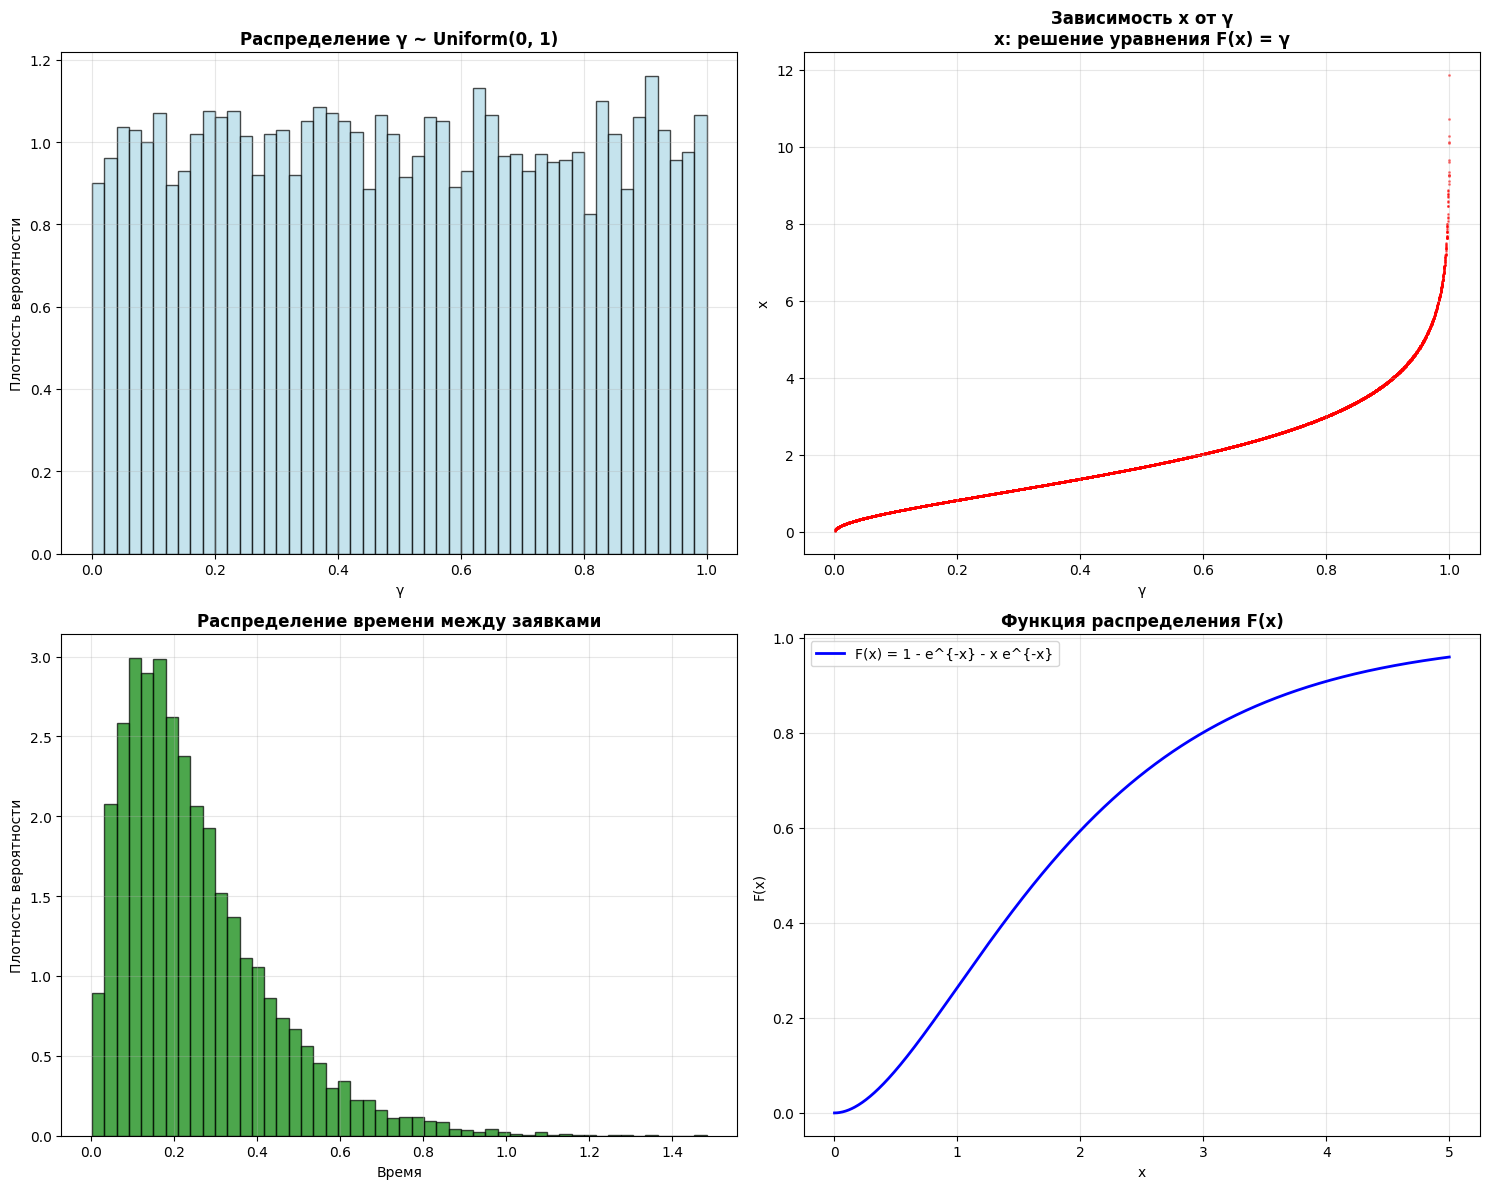


2. Анализ уравнения распределения...


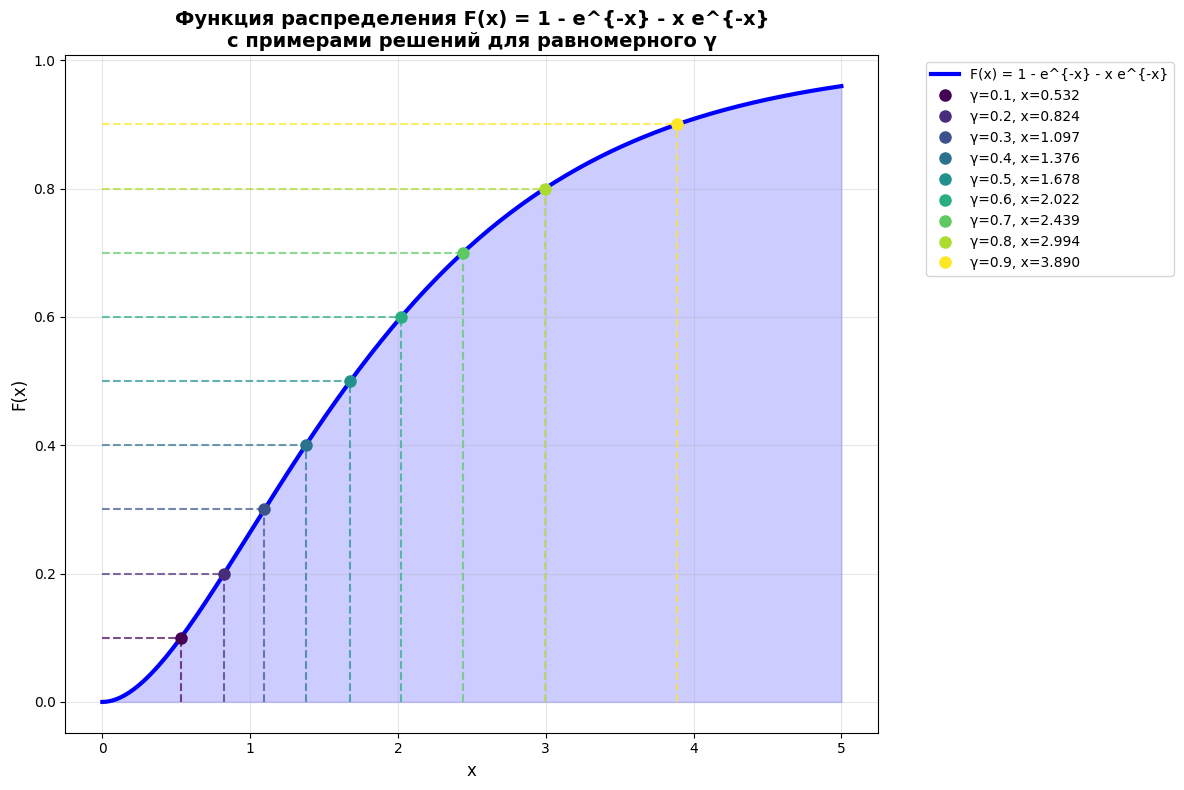


3. Моделирование системы...
Начало моделирования СМО...

ПАРАМЕТРЫ СИСТЕМЫ МАССОВОГО ОБСЛУЖИВАНИЯ
Теоретическая (заданная) нтенсивность потока (λ): 8
Теоретическая (заданная) нтенсивность обслуживания (μ): 5
Количество каналов: 3
Вместимость очереди: 4
Общая вместимость системы: 7
Время моделирования: 1000
Теоретическая нагрузка (ρ): 0.5333
Моделирование завершено.

4. Анализ результатов...

ДЕТАЛЬНЫЙ ОТЧЕТ ПО СИСТЕМЕ МАССОВОГО ОБСЛУЖИВАНИЯ

📈 ОСНОВНЫЕ ХАРАКТЕРИСТИКИ:
   Всего заявок: 3943
   Обслужено заявок: 3934
   Отклонено заявок: 9
   Вероятность отказа: 0.0023
   Пропускная способность: 3.9340 заявок/ед.времени

⏱️  ВРЕМЕННЫЕ ХАРАКТЕРИСТИКИ:
   Среднее время ожидания: 0.1078
   Среднее время обслуживания: 0.3991
   Среднее время в системе: 0.5069
   Максимальное время ожидания: 2.9538

📊 ХАРАКТЕРИСТИКИ ОЧЕРЕДИ:
   Средняя длина очереди: 0.5531
   Максимальная длина очереди: 4
   Вероятность очереди: 0.3211

⚙️  ХАРАКТЕРИСТИКИ КАНАЛОВ:
   Среднее число занятых каналов: 2.1981
  

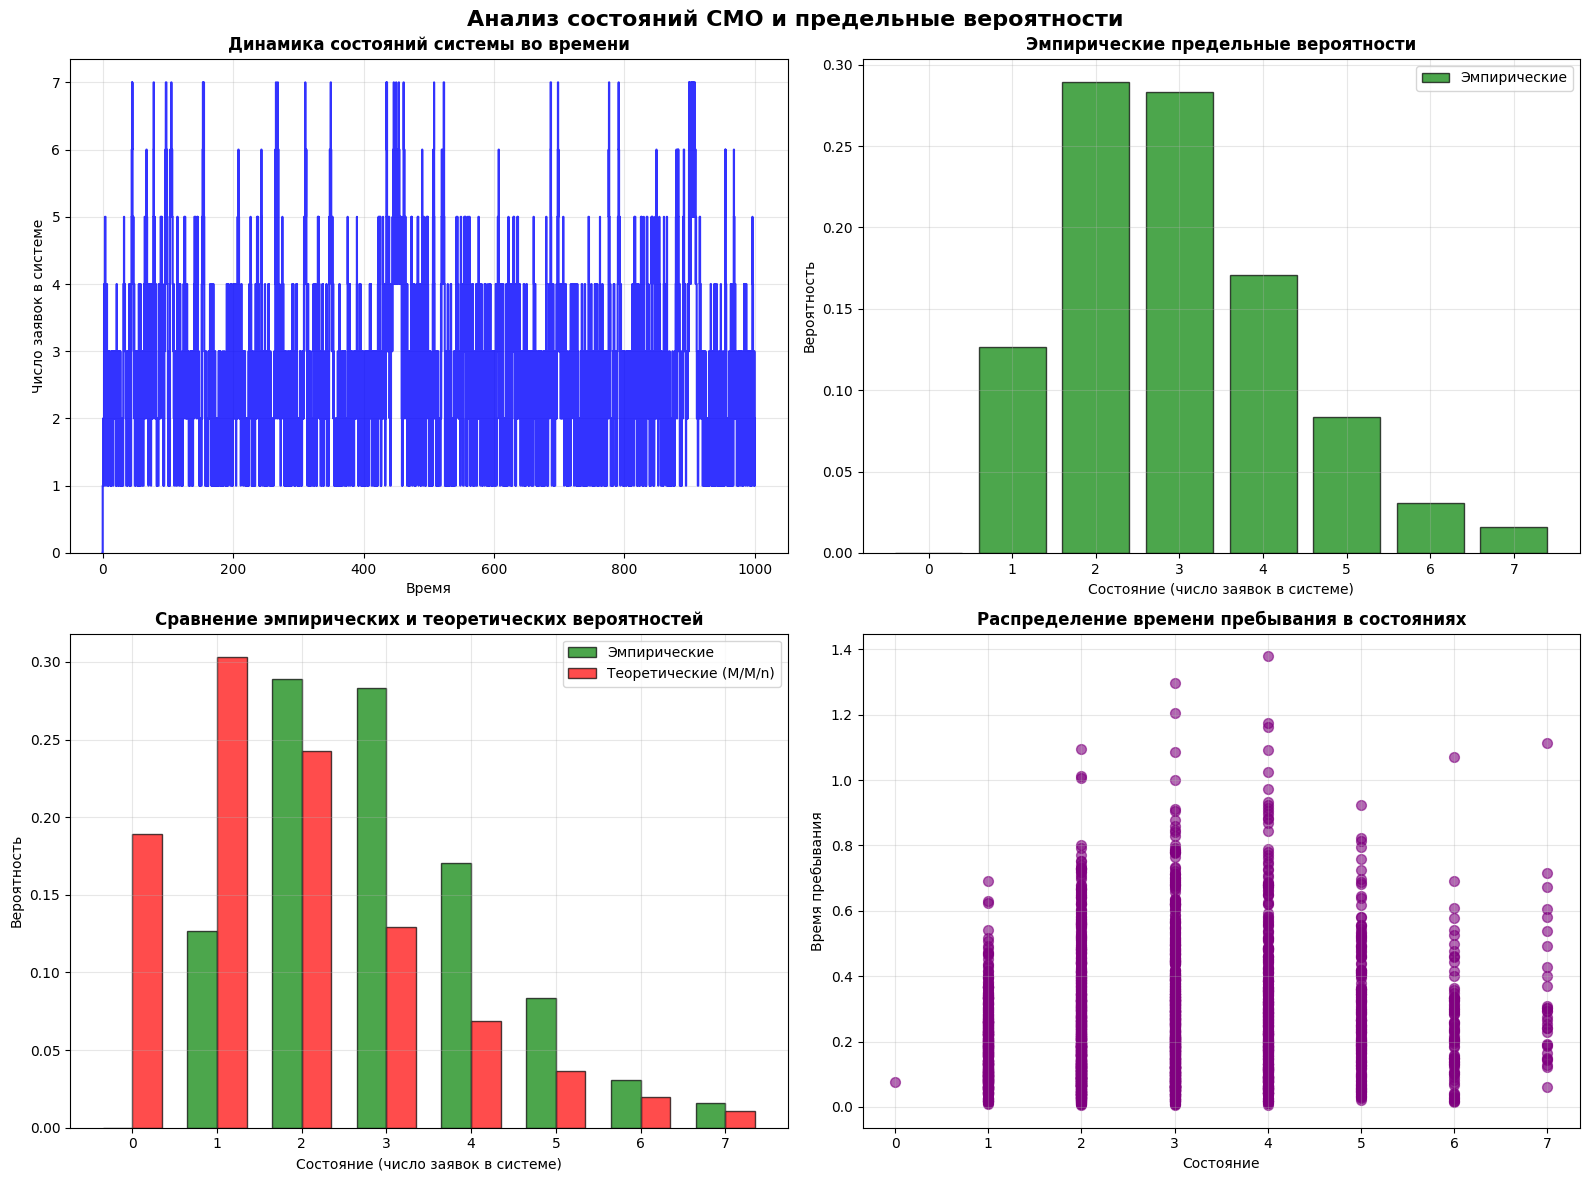


ТАБЛИЦА ПРЕДЕЛЬНЫХ ВЕРОЯТНОСТЕЙ СОСТОЯНИЙ СИСТЕМЫ
 Состояние Эмпирическая Теоретическая   Ошибка                      Описание
         0     0.000118      0.189404 0.189286                 Система пуста
         1     0.126502      0.303046 0.176543       1 заявок в обслуживании
         2     0.289162      0.242437 0.046725       2 заявок в обслуживании
         3     0.283396      0.129299 0.154096       3 заявок в обслуживании
         4     0.170538      0.068960 0.101579 3 в обслуживании, 1 в очереди
         5     0.083393      0.036779 0.046614 3 в обслуживании, 2 в очереди
         6     0.030893      0.019615 0.011278 3 в обслуживании, 3 в очереди
         7     0.015998      0.010461 0.005537 3 в обслуживании, 4 в очереди

Сумма эмпирических вероятностей: 1.000000
Сумма теоретических вероятностей: 1.000000

7. Построение комплексных графиков...


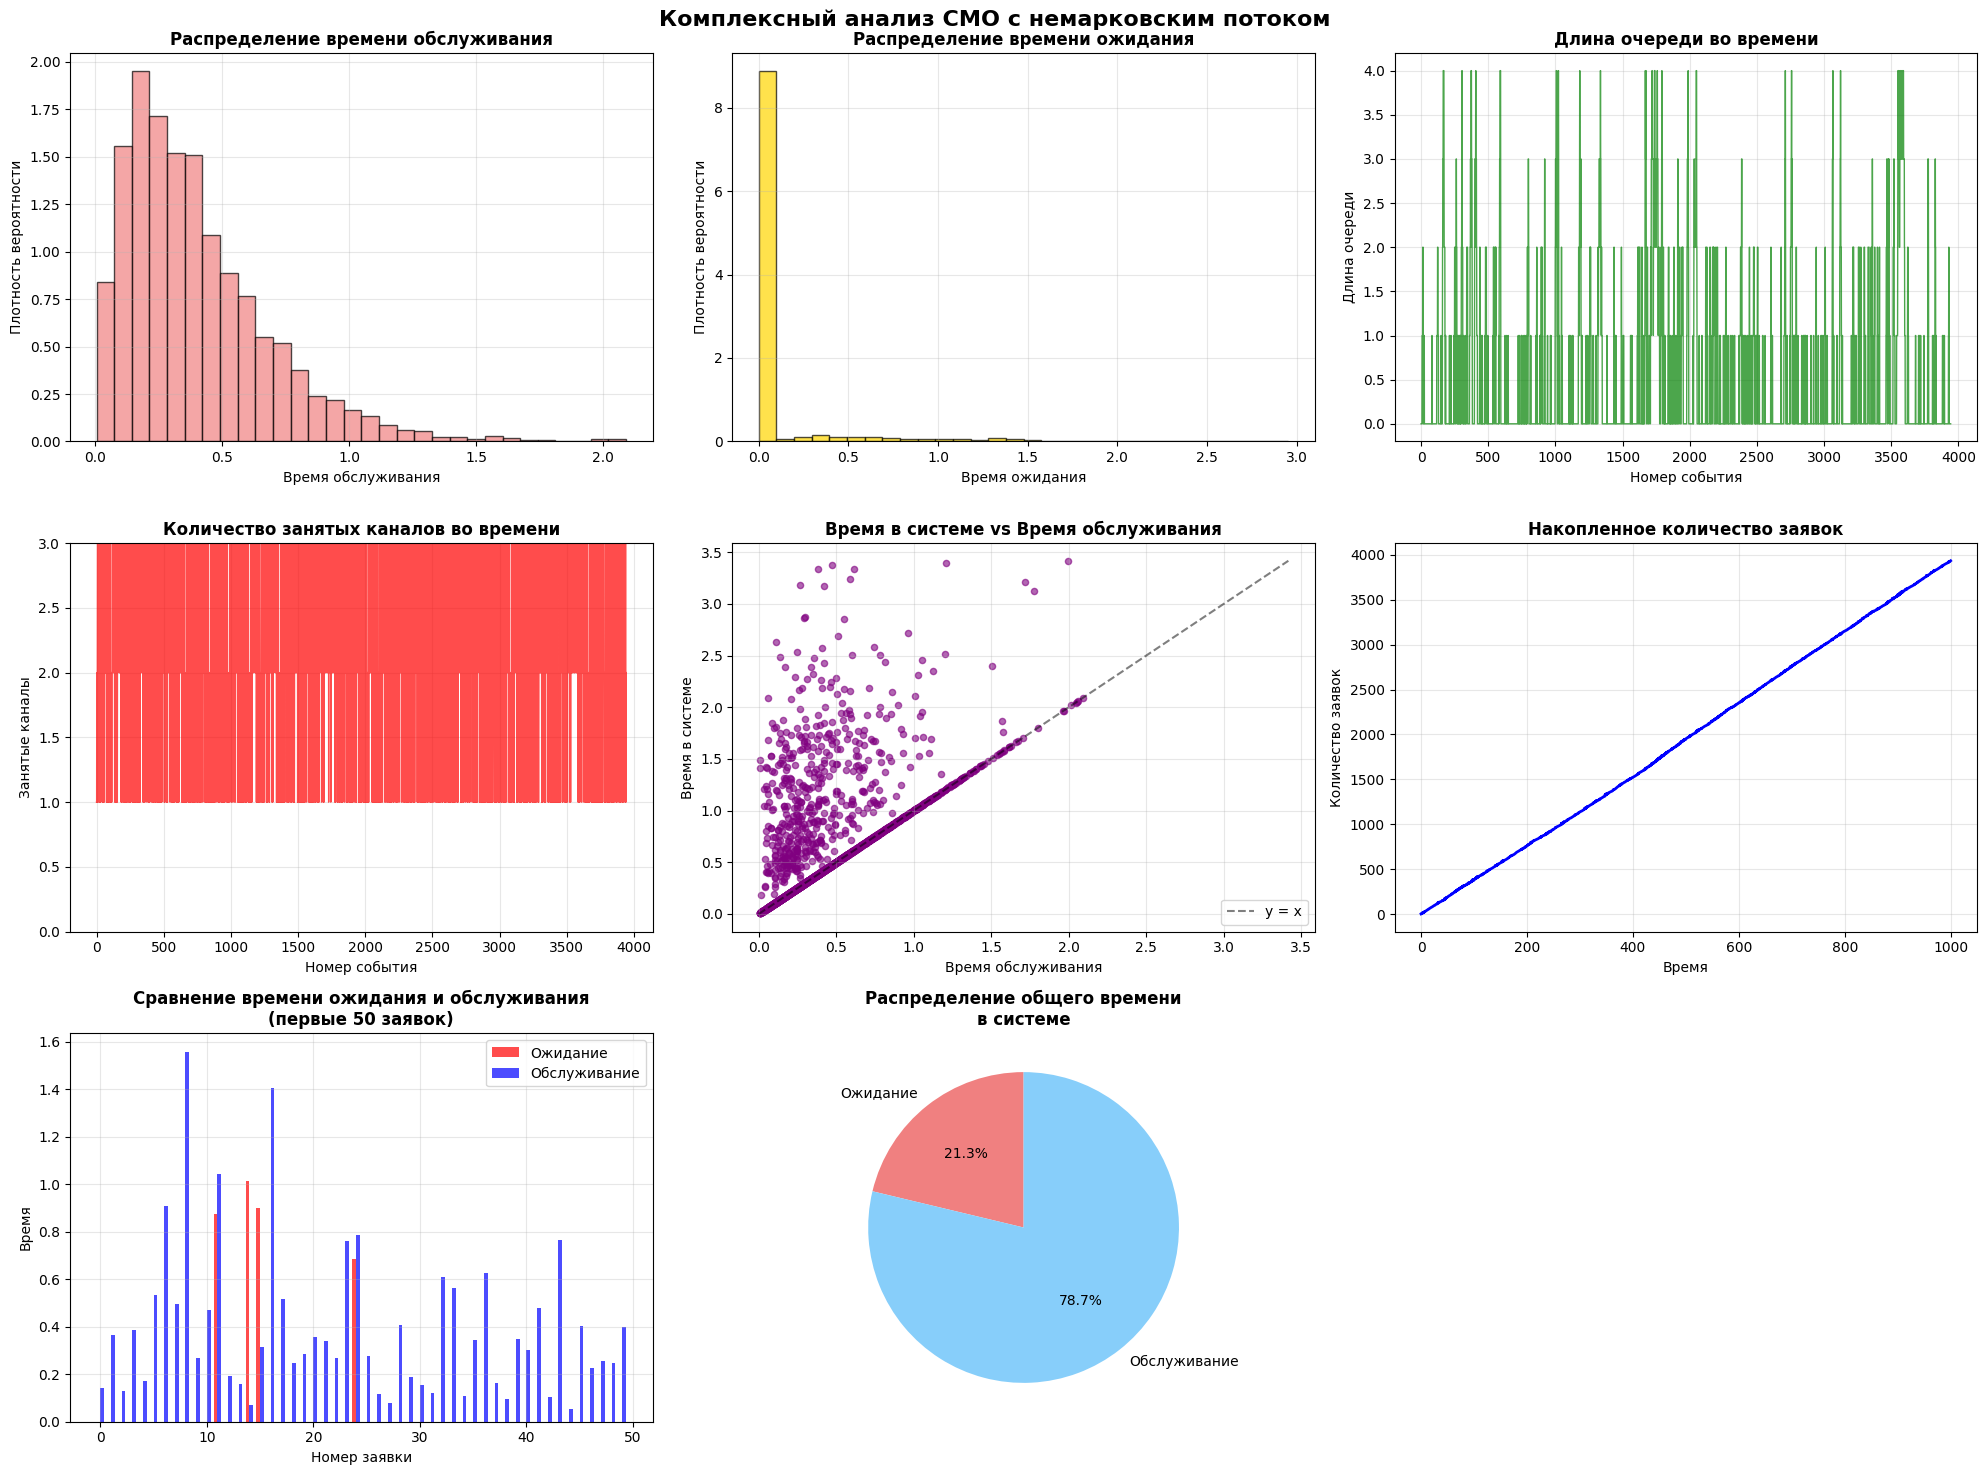


Анализ завершен успешно!


In [75]:
# ЗАПУСК ПРОГРАММЫ
print("ЗАПУСК СИСТЕМЫ МАССОВОГО ОБСЛУЖИВАНИЯ")
print("="*50)

# Создаем систему
system = NonMarkovQueueSystem(**config)

# 1. Анализ распределения гамма и времен
print("\n1. Анализ распределения γ и генерируемых времен...")
system.analyze_gamma_distribution()

# 2. Показываем график уравнения
print("\n2. Анализ уравнения распределения...")
system.analyze_equation_behavior()

# 3. Запускаем моделирование
print("\n3. Моделирование системы...")
system.simulate_queue_system()

# 4. Выводим отчет
print("\n4. Анализ результатов...")
metrics = system.print_detailed_report()

# 5 Сравнение характеристик
print("\n5. Сравнение характеристик...")
metrics = system.print_comparison_report()

# 6. Анализ состояний
print("\n6. Анализ состояний системы...")
system.plot_state_analysis()

# 7. Комплексные графики
print("\n7. Построение комплексных графиков...")
system.plot_comprehensive_results()

print("\nАнализ завершен успешно!")
